In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# path to dataset folder
dataset_path = '/content/drive/My Drive/Final Stuff/'

# loading annotatons function
def load_annotations(file_path, subfolder):
    annotations = []

    with open(file_path, 'r') as f:
        for line in f:
            # finding labels at the end of youtube video names
            match = re.search(r'([A-Za-z]*\d+)$', line.strip())

            if match:
                label = match.group(1)
                video_path = line[:match.start()].strip()
                # add label to video filename and add .mp4 extension
                video_filename = f"{video_path} {label}.mp4".strip()
                video_full_path = os.path.join(dataset_path, 'oops_video', subfolder, video_filename)
                annotations.append((video_full_path, label))
            else:
                print(f"Skipping line: {line.strip()}")
    return annotations

train_annotations = load_annotations('/content/drive/My Drive/Final Stuff/train.txt', 'train')
val_annotations = load_annotations('/content/drive/My Drive/Final Stuff/val.txt', 'val')

print(f"Training samples: {len(train_annotations)}")
print(f"Validation samples: {len(val_annotations)}")

Training samples: 23201
Validation samples: 6739


In [11]:
# function to preprocess a video and save frames as NumPy arrays
def preprocess_video(video_path, output_dir, target_size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()

    while success:
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_file = os.path.join(output_dir, f"frame_{frame_count:04d}.npy")
        np.save(frame_file, frame)
        frame_count += 1
        success, frame = cap.read()

    cap.release()
    print(f"Preprocessed {frame_count} frames from {video_path}")


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, annotations, transform=None):
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        video_full_path, label = self.annotations[idx]
        print(f"Loading video: {video_full_path}")

        video = self.load_video(video_full_path, label)
        if self.transform:
            video = self.transform(video)
        return video, label, video_full_path

    def load_video(self, video_full_path, label):
        frames = []
        if not os.path.exists(video_full_path):
            print(f"Error: Video file does not exist: {video_full_path} with label: {label}")
            print(f"Expected video path: {os.path.abspath(video_full_path)}")
            return torch.zeros((1, 224, 224, 3))

        cap = cv2.VideoCapture(video_full_path)
        if not cap.isOpened():
            print(f"Error: Could not open video: {video_full_path}")
            return torch.zeros((1, 224, 224, 3))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        if len(frames) == 0:
            print(f"No frames found for video: {video_full_path} with label: {label}")
            frames = torch.zeros((1, 224, 224, 3))  # change to single black frame with correct dimensions
        else:
            frames = torch.tensor(frames)
            if frames.ndim == 4:  # check frames tensor has correct dimensions
                frames = frames.permute(3, 0, 1, 2)
            else:
                print(f"Unexpected frame dimensions for video: {video_full_path} with label: {label}")
                frames = torch.zeros((1, 3, 224, 224))  # Default to a single black frame with correct dimensions

        return frames

# Create datasets
train_dataset = VideoDataset(train_annotations)
val_dataset = VideoDataset(val_annotations)

# Create dataloaders
train_load = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_load = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

print(f"Number of training batches: {len(train_load)}")
print(f"Number of validation batches: {len(val_load)}")


def verify_dataset(loader):
    for i, batch in enumerate(loader):
        videos, labels, video_paths = batch
        # print(f"Batch {i + 1}")
        # print(f"Video batch shape: {videos.shape}")
        # print(f"Labels: {labels}")
        # print(f"Video paths: {video_paths}")

        for video_path in video_paths:
            # Check if the video file exists
            if not os.path.exists(video_path):
                print(f"Error2: Video file does not exist: {video_path}")
            else:
                print(f"Video file exists: {video_path}")

        if i == 2:  # check only the first 3 batches
            break

# verify the training dataset
print("Verifying training dataset:")
verify_dataset(train_load)

# verify the validation dataset
print("Verifying validation dataset:")
verify_dataset(val_load)

Number of training batches: 5801
Number of validation batches: 1685
Verifying training dataset:
Loading video: /content/drive/My Drive/Final Stuff/oops_video/train/My Twig and Berries - Cup Check (February 2019) _ FailArmy40.mp4Loading video: /content/drive/My Drive/Final Stuff/oops_video/train/Best Fails of the Week 1 May 2016 _ 'That Squirrel Just Attacked Me! by FailArmy79.mp4

Loading video: /content/drive/My Drive/Final Stuff/oops_video/train/Instant Karma Fails - It's Payback Time (December 2016) _ FailArmy7.mp4
Loading video: /content/drive/My Drive/Final Stuff/oops_video/train/FailArmy After Dark - Sliding Into The Weekend (Ep. 11) 90.mp4Error: Video file does not exist: /content/drive/My Drive/Final Stuff/oops_video/train/FailArmy After Dark - Sliding Into The Weekend (Ep. 11) 90.mp4 with label: 90

Expected video path: /content/drive/My Drive/Final Stuff/oops_video/train/FailArmy After Dark - Sliding Into The Weekend (Ep. 11) 90.mp4
Loading video: /content/drive/My Drive/Fina

KeyboardInterrupt: 

File exists


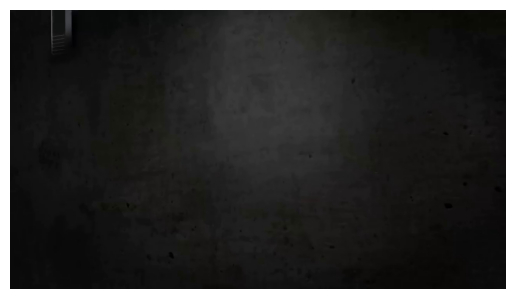

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# check if file exists
video_path = r'/content/drive/My Drive/Final Stuff/oops_video/train/There Was An Attempt, Then A Fail (March 2018) _ FailArmy1.mp4'
if os.path.exists(video_path):
    print("File exists")
else:
    print("File does not exist")

# open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video {video_path}")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame from video {video_path}")
            break
        # display the frame for testing
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        break  # only first frame
    cap.release()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

def speed_module(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = Flatten()(x)

    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)

    return model

KeyboardInterrupt: 

In [10]:
import torch
from timesformer.models.vit import TimeSformer

model = TimeSformer(img_size=224, num_classes=400, num_frames=8, attention_type='divided_space_time',  pretrained_model='/content/drive/My Drive/Final Stuff/T-K400.pyth')

dummy_video = torch.randn(2, 3, 8, 224, 224) # (batch x channels x frames x height x width)

pred = model(dummy_video,) # (2, 400)

ModuleNotFoundError: No module named 'timesformer'